In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
# reinforcement learning
import gym
from gym import error, spaces, utils
from gym.utils import seeding

from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, BatchNormalization, Conv1D, InputLayer, Dropout, regularizers, Conv2D, Reshape
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu

Using TensorFlow backend.


In [3]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

In [4]:
window_length = 50

# Environment

You can see the base environment class [here](https://github.com/openai/gym/blob/master/gym/core.py#L13) and openai's nice docs [here](https://gym.openai.com/docs). My environment is in `src/environments/portfolio.py` and the PortfolioEnvironment load a datasource and simulation subclass.


In [5]:
from src.environments.portfolio import PortfolioEnv

In [6]:
df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
env = PortfolioEnv(
    df=df_train,
    steps=30, 
    scale=True, 
    augment=0.0000, # let just overfit first,
    trading_cost=0, # let just overfit first,
    window_length = window_length,
    
)
env.seed = 0   

df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
env_test = PortfolioEnv(
    df=df_test,
    steps=30, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env_test.seed = 0  

# Model

arXiv:1612.01277 indicated that CNN's are just as effective. That's great because I like them, they are fast so I can try more things and see the results faster. So we will be using a CNN model.


In [7]:
from keras.layers import Input, merge, Reshape
from keras.layers import concatenate, Conv2D
from keras.regularizers import l2, l1_l2
from keras.models import Model

window_length=50
nb_actions=env.action_space.shape[0]
reg=1e-8

# Simple CNN actor model
actor = Sequential()
actor.add(InputLayer(input_shape=(1,)+env.observation_space.shape))
actor.add(Reshape(env.observation_space.shape))
actor.add(Conv2D(
    filters=2,
    kernel_size=(1,3),
    kernel_regularizer=l2(reg),
    activation='relu'
))
actor.add(BatchNormalization()) # lets add batch norm to decrease training time

actor.add(Conv2D(
    filters=20,
    kernel_size=(1,window_length-2),
    kernel_regularizer=l2(reg),
    activation='relu'
))
actor.add(BatchNormalization())

actor.add(Conv2D(
    filters=1,
    kernel_size=(1,1),
    kernel_regularizer=l2(reg),
    activation='relu'
))
actor.add(BatchNormalization())

actor.add(Flatten())
actor.add(Dense(
    nb_actions, 
    kernel_regularizer=l2(reg)
)) # this adds cash bias
actor.add(Activation('softmax'))
print(actor.summary())

# Lets have nice flexible critic so it can approximate the Q-function
action_input = Input(shape=(nb_actions,), name='action_input')

observation_input = Input(shape=(1,)+env.observation_space.shape, name='observation_input')
y = Reshape(env.observation_space.shape)(observation_input)

y = Conv2D(
    filters=2,
    kernel_size=(1,3),
    kernel_regularizer=l2(reg),
    activation='relu'
)(y)
y = BatchNormalization()(y) # lets add batch norm to decrease training time

y = Conv2D(
    filters=20,
    kernel_size=(1,window_length-2),
    kernel_regularizer=l2(reg),
    activation='relu'
)(y)
y = BatchNormalization()(y)

y = Flatten()(y)

x = concatenate([action_input, y])
x = Dense(128)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)

x = Dense(32)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)

x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 5, 50, 3)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 50, 3)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 48, 2)          20        
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 48, 2)          8         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 1, 20)          1940      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 1, 20)          80        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 1, 1)           21        
__________

# Agent

In [8]:
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

# We configure and compile our agent.

# We are providing the last 50 steps so we don't need memory, use window_lenght=1 as placeholder
memory = SequentialMemory(limit=1000, window_length=1)

random_process = OrnsteinUhlenbeckProcess(
    size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(
    nb_actions=nb_actions,
    actor=actor,
    critic=critic,
    critic_action_input=action_input,
    random_process=random_process,
    memory=memory,
    batch_size=50,
    nb_steps_warmup_critic=100,
    nb_steps_warmup_actor=100,    
    gamma=.00, # discounted factor of zero as per paper
    target_model_update=1e-3
)

agent.compile(Adam(lr=3e-5), metrics=['mse'])
agent

# Train

In [9]:
from src.callbacks.keras_rl_callbacks import TrainIntervalLoggerTQDMNotebook

In [10]:
def sharpe(returns, freq=30, rfr=0):
    """Given a set of returns, calculates naive (rfr=0) sharpe (eq 28) """
    return (np.sqrt(freq) * np.mean(returns-rfr)) / np.std(returns - rfr)


def MDD(returns):
    """Max drawdown."""
    peak = returns.max()
    i = returns.argmax()
    trough = returns[returns.argmax():].min()
    return (trough-peak)/trough 

In [11]:
# # https://github.com/matthiasplappert/keras-rl/blob/master/rl/callbacks.py#L104
from rl.callbacks import TrainEpisodeLogger
class TrainEpisodeLoggerPortfolio(TrainEpisodeLogger):
    """Print custom stats every <log_intv> episode."""
    def __init__(self, log_intv):
        super().__init__()
        self.log_intv=log_intv
        self.episode_metrics={} # custom metrics
    def on_episode_end(self, episode, logs):
        
        # save custom metrics
        df = pd.DataFrame(self.env.infos)
        self.episode_metrics[episode]=dict(
            max_drawdown=MDD(df.rate_of_return+1), 
            sharpe=sharpe(df.rate_of_return+1), 
            accumulated_portfolio_value=df.portfolio_value.iloc[-1],
            mean_market_return=df.mean_market_returns.cumprod().iloc[-1],
            cash_bias=df.weights.apply(lambda x:x[0]).mean()
        )
        
        if episode%self.log_intv==0:
            # print normal metrics
            super().on_episode_end(episode, logs)
            
            # print custom metrics for last N episodes
            df = pd.DataFrame(self.episode_metrics).T[-self.log_intv:]          
            for col in df.columns:
                print('{name:25.25s}: {mean: 10.6f} [{min: 10.6f}, {max: 10.6f}]'.format(
                    name=df[col].name, 
                    min=df[col].min(), 
                    mean=df[col].mean(), 
                    max=df[col].max(), 
                ))
            print('')           
        

In [12]:
from rl.callbacks import ModelIntervalCheckpoint
save_path= 'outputs/agent_portfolio-ddpg-keras/agent_{}_weights.h5f'.format('portfolio-ddpg-keras-rl')

In [15]:
agent.load_weights(save_path)

In [ ]:
history = agent.fit(env, 
                  nb_steps=2e6, 
                  visualize=False, 
                  verbose=0,
                  callbacks=[
                      TrainIntervalLoggerTQDMNotebook(),
                      TrainEpisodeLoggerPortfolio(500),
                      ModelIntervalCheckpoint(save_path, 500*30, 1)
                    ]
                 )

# After training is done, we save the final weights.
agent.save_weights(save_path, overwrite=True)

Training for 2000000.0 steps ...
Training for 2000000.0 steps ...
Interval 1 (0 steps performed)
      30/2000000.0: episode: 1, duration: 0.252s, episode steps: 30, steps per second: 119, episode reward: 0.000, mean reward: 0.000 [-0.000, 0.000], mean action: 0.132 [-0.286, 0.445], mean observation: 0.986 [0.916, 1.049], loss: --, mean_squared_error: --, mean_q: --
accumulated_portfolio_val:   1.007654 [  1.007654,   1.007654]
cash_bias                :   0.182006 [  0.182006,   0.182006]
max_drawdown             :  -0.016880 [ -0.016880,  -0.016880]
mean_market_return       :   1.008074 [  1.008074,   1.008074]
sharpe                   :  1373.525454 [ 1373.525454,  1373.525454]

333 episodes - episode_reward: 0.000 [-0.005, 0.008] - loss: 0.069 - mean_squared_error: 0.138 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.006 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490 - cash_bias: 0.159 - mean_market_returns: 1.000

Interval 2 (10000 steps performed)

  105030/2000000.0: episode: 3501, duration: 0.920s, episode steps: 30, steps per second: 33, episode reward: -0.001, mean reward: -0.000 [-0.000, 0.000], mean action: 0.219 [0.012, 0.729], mean observation: 1.009 [0.943, 1.100], loss: 0.000000, mean_squared_error: 0.000000, mean_q: -0.000001
accumulated_portfolio_val:   1.008412 [  0.908828,   1.213078]
cash_bias                :   0.188269 [  0.039821,   0.434827]
max_drawdown             :  -0.019754 [ -0.255824,   0.000000]
mean_market_return       :   1.007514 [  0.919927,   1.132786]
sharpe                   :  1333.031619 [ 168.770046,  2959.971925]

333 episodes - episode_reward: 0.000 [-0.003, 0.006] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.002 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500 - cash_bias: 0.165 - mean_market_returns: 1.000

Interval 12 (110000 steps performed)
Step 120000: saving model to outputs/agent_portfolio-ddpg-keras/agent_por

  210030/2000000.0: episode: 7001, duration: 1.019s, episode steps: 30, steps per second: 29, episode reward: 0.001, mean reward: 0.000 [-0.000, 0.000], mean action: 0.209 [0.071, 0.442], mean observation: 1.004 [0.908, 1.077], loss: 0.000000, mean_squared_error: 0.000000, mean_q: 0.000004
accumulated_portfolio_val:   1.004450 [  0.886004,   1.140253]
cash_bias                :   0.188195 [  0.042458,   0.426703]
max_drawdown             :  -0.019503 [ -0.093260,   0.000000]
mean_market_return       :   1.005047 [  0.881979,   1.157721]
sharpe                   :  1311.064921 [ 316.101648,  3452.464668]

333 episodes - episode_reward: 0.000 [-0.004, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490 - cash_bias: 0.161 - mean_market_returns: 1.000

Interval 23 (220000 steps performed)
Step 225000: saving model to outputs/agent_portfolio-ddpg-keras/agent_portfo

333 episodes - episode_reward: 0.000 [-0.003, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500 - cash_bias: 0.166 - mean_market_returns: 1.000

Interval 33 (320000 steps performed)
Step 330000: saving model to outputs/agent_portfolio-ddpg-keras/agent_portfolio-ddpg-keras-rl_weights.h5f
334 episodes - episode_reward: 0.000 [-0.004, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510 - cash_bias: 0.170 - mean_market_returns: 1.000

Interval 34 (330000 steps performed)
  330030/2000000.0: episode: 11001, duration: 1.287s, episode steps: 30, steps per second: 23, episode reward: 0.000, mean reward: 0.000 [-0.000, 0.000], mean action: 0.192 [-0.053, 0.558], mean observation: 1.010 [0.942, 1.126], loss: 0.000000, mean_squared_error: 0.00

333 episodes - episode_reward: 0.000 [-0.004, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.490 - cash_bias: 0.164 - mean_market_returns: 1.000

Interval 44 (430000 steps performed)
Step 435000: saving model to outputs/agent_portfolio-ddpg-keras/agent_portfolio-ddpg-keras-rl_weights.h5f
  435030/2000000.0: episode: 14501, duration: 0.925s, episode steps: 30, steps per second: 32, episode reward: 0.000, mean reward: 0.000 [-0.000, 0.000], mean action: 0.172 [0.020, 0.425], mean observation: 0.998 [0.918, 1.067], loss: 0.000000, mean_squared_error: 0.000001, mean_q: 0.000001
accumulated_portfolio_val:   1.006388 [  0.858304,   1.202730]
cash_bias                :   0.190565 [  0.037799,   0.707949]
max_drawdown             :  -0.018822 [ -0.180411,   0.000000]
mean_market_return       :   1.008133 [  0.926452,   1.181485]
sharpe                   :  1372.02842

Step 540000: saving model to outputs/agent_portfolio-ddpg-keras/agent_portfolio-ddpg-keras-rl_weights.h5f
334 episodes - episode_reward: 0.000 [-0.003, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.003 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510 - cash_bias: 0.161 - mean_market_returns: 1.000

Interval 55 (540000 steps performed)
  540030/2000000.0: episode: 18001, duration: 1.021s, episode steps: 30, steps per second: 29, episode reward: 0.001, mean reward: 0.000 [-0.000, 0.000], mean action: 0.199 [0.035, 0.542], mean observation: 1.006 [0.885, 1.221], loss: 0.000000, mean_squared_error: 0.000000, mean_q: 0.000003
accumulated_portfolio_val:   1.007506 [  0.909215,   1.126274]
cash_bias                :   0.186955 [  0.039340,   0.691189]
max_drawdown             :  -0.019185 [ -0.078987,   0.000000]
mean_market_return       :   1.008276 [  0.923179,   1.120255]
sharpe                   :  1317.90650

Step 645000: saving model to outputs/agent_portfolio-ddpg-keras/agent_portfolio-ddpg-keras-rl_weights.h5f
  645030/2000000.0: episode: 21501, duration: 0.917s, episode steps: 30, steps per second: 33, episode reward: 0.001, mean reward: 0.000 [-0.000, 0.000], mean action: 0.152 [-0.074, 0.381], mean observation: 0.999 [0.915, 1.067], loss: 0.000000, mean_squared_error: 0.000000, mean_q: 0.000005
accumulated_portfolio_val:   1.008039 [  0.936919,   1.104805]
cash_bias                :   0.193676 [  0.037411,   0.514672]
max_drawdown             :  -0.018117 [ -0.116132,   0.000000]
mean_market_return       :   1.007928 [  0.908750,   1.090569]
sharpe                   :  1390.545731 [ 359.563258,  3465.775387]

333 episodes - episode_reward: 0.000 [-0.002, 0.003] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500 - cash_bias: 0.167 - mean_market_returns: 1.000

Inter

334 episodes - episode_reward: 0.000 [-0.004, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.005 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510 - cash_bias: 0.168 - mean_market_returns: 1.000

Interval 76 (750000 steps performed)
  750030/2000000.0: episode: 25001, duration: 1.029s, episode steps: 30, steps per second: 29, episode reward: 0.001, mean reward: 0.000 [-0.000, 0.000], mean action: 0.177 [-0.111, 0.371], mean observation: 1.001 [0.936, 1.059], loss: 0.000000, mean_squared_error: 0.000000, mean_q: 0.000012
accumulated_portfolio_val:   1.008105 [  0.899895,   1.129424]
cash_bias                :   0.196373 [  0.045188,   0.582827]
max_drawdown             :  -0.018993 [ -0.124283,   0.000000]
mean_market_return       :   1.008604 [  0.896634,   1.110635]
sharpe                   :  1331.409081 [ 153.182229,  3387.408001]

333 episodes - episode_reward: 0.000 [-0.004, 0.004] - loss: 0.000 - mean_

Step 855000: saving model to outputs/agent_portfolio-ddpg-keras/agent_portfolio-ddpg-keras-rl_weights.h5f
  855030/2000000.0: episode: 28501, duration: 0.914s, episode steps: 30, steps per second: 33, episode reward: 0.001, mean reward: 0.000 [-0.000, 0.000], mean action: 0.132 [-0.095, 0.374], mean observation: 0.988 [0.874, 1.078], loss: 0.000000, mean_squared_error: 0.000000, mean_q: 0.000004
accumulated_portfolio_val:   1.008358 [  0.891976,   1.111605]
cash_bias                :   0.193507 [  0.041040,   0.526186]
max_drawdown             :  -0.019878 [ -0.150882,   0.000000]
mean_market_return       :   1.009528 [  0.897183,   1.157721]
sharpe                   :  1315.658711 [ 217.215553,  7279.484873]

333 episodes - episode_reward: 0.000 [-0.003, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500 - cash_bias: 0.172 - mean_market_returns: 1.000

Inter

334 episodes - episode_reward: 0.000 [-0.005, 0.006] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510 - cash_bias: 0.167 - mean_market_returns: 1.000

Interval 97 (960000 steps performed)
  960030/2000000.0: episode: 32001, duration: 1.037s, episode steps: 30, steps per second: 29, episode reward: 0.000, mean reward: 0.000 [-0.000, 0.000], mean action: 0.192 [-0.106, 0.476], mean observation: 1.021 [0.798, 1.181], loss: 0.000000, mean_squared_error: 0.000000, mean_q: 0.000010
accumulated_portfolio_val:   1.006898 [  0.866798,   1.192563]
cash_bias                :   0.191934 [  0.038739,   0.466768]
max_drawdown             :  -0.018200 [ -0.114583,   0.000000]
mean_market_return       :   1.006641 [  0.850965,   1.097022]
sharpe                   :  1389.483499 [ 203.524275,  3552.470681]

333 episodes - episode_reward: 0.000 [-0.004, 0.004] - loss: 0.000 - mean_

Step 1065000: saving model to outputs/agent_portfolio-ddpg-keras/agent_portfolio-ddpg-keras-rl_weights.h5f
 1065030/2000000.0: episode: 35501, duration: 0.955s, episode steps: 30, steps per second: 31, episode reward: 0.001, mean reward: 0.000 [-0.000, 0.000], mean action: 0.181 [-0.036, 0.414], mean observation: 0.995 [0.899, 1.067], loss: 0.000000, mean_squared_error: 0.000000, mean_q: 0.000009
accumulated_portfolio_val:   1.007051 [  0.901042,   1.200060]
cash_bias                :   0.197430 [  0.039150,   0.580278]
max_drawdown             :  -0.018875 [ -0.172364,   0.000000]
mean_market_return       :   1.007665 [  0.835000,   1.170414]
sharpe                   :  1394.855418 [ 231.936978,  3841.618544]

333 episodes - episode_reward: 0.000 [-0.003, 0.004] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.002 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.500 - cash_bias: 0.166 - mean_market_returns: 1.000

Inte

Step 1170000: saving model to outputs/agent_portfolio-ddpg-keras/agent_portfolio-ddpg-keras-rl_weights.h5f
334 episodes - episode_reward: 0.000 [-0.008, 0.005] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - reward: 0.000 - log_return: 0.000 - portfolio_value: 1.004 - rate_of_return: 0.000 - cost: 0.000 - steps: 16.510 - cash_bias: 0.166 - mean_market_returns: 1.000

Interval 118 (1170000 steps performed)
 1170030/2000000.0: episode: 39001, duration: 1.027s, episode steps: 30, steps per second: 29, episode reward: 0.001, mean reward: 0.000 [-0.000, 0.000], mean action: 0.155 [-0.105, 0.424], mean observation: 0.990 [0.896, 1.043], loss: 0.000000, mean_squared_error: 0.000000, mean_q: -0.000001
accumulated_portfolio_val:   1.005816 [  0.781733,   1.184502]
cash_bias                :   0.194062 [  0.042417,   0.438133]
max_drawdown             :  -0.018857 [ -0.111280,   0.000000]
mean_market_return       :   1.007057 [  0.847730,   1.117254]
sharpe                   :  1345.

In [1]:
agent.save_weights('outputs/agent_portfolio-ddpg-keras/agent_{}_weights.h5f'.format('portfolio-ddpg-keras-rl'), overwrite=True)

NameError: name 'agent' is not defined

# Test

Testing for 1 episodes ...
Episode 1: reward: 0.000, steps: 7613
APV (Accumulated portfolio value): 	 28.713756
SR (Sharpe ratio):                 	 676.338784
MDD (max drawdown):                	-17.556893%



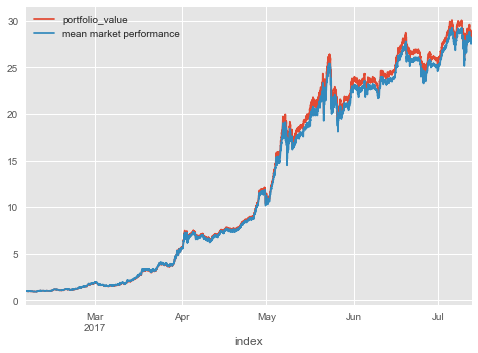

In [16]:
# one big test
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
steps=len(df_test)-window_length-2
env_test = PortfolioEnv(
    df=df_test,
    steps=steps, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env_test.seed = 0  
agent.test(env_test, nb_episodes=1, visualize=False)

df = pd.DataFrame(env_test.infos)
df.index=df['index']

s=sharpe(df.rate_of_return+1)
mdd=MDD(df.rate_of_return+1)
print('APV (Accumulated portfolio value): \t{: 2.6f}'.format(df.portfolio_value.iloc[-1]))
print('SR (Sharpe ratio):                 \t{: 2.6f}'.format( s))
print('MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
print('')

# show one run vs average market performance
df.portfolio_value.plot()
df.mean_market_returns.cumprod().plot(label='mean market performance')
plt.legend()

In [ ]:
# The weights appear to be static, so the model hasn't learnt much
df.index = df['index']
df.weights.apply(lambda x:x.std())

In [ ]:
# Lets evaluate a few 30 step intervals
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
env_test = PortfolioEnv(
    df=df_test,
    steps=30, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env_test.seed = 0  

for i in range(10):
    agent.test(env_test, nb_episodes=1, visualize=False)
    df = pd.DataFrame(env_test.infos)
    s=sharpe(df.rate_of_return+1)
    mdd=MDD(df.rate_of_return+1)
    print('APV (Accumulated portfolio value): \t{: 2.6f}'.format(df.portfolio_value.iloc[-1]))
    print('SR (Sharpe ratio):                 \t{: 2.6f}'.format( s))
    print('MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
    print('')
    df.portfolio_value.plot(label=str(i))
plt.legend()

# Visualise

In [ ]:
# history
df_hist = pd.DataFrame(history.history)
df_hist
df_hist['episodes'] = df_hist.index

g = sns.jointplot(x="episodes", y="episode_reward", data=df_hist, kind="reg", size=10)
plt.show()

# g = sns.jointplot(x="episodes", y="rewards", data=history, kind="reg")

# dummy metrics

TODO